In [145]:
from keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from tensorflow import keras

In [146]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, beta, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.beta = beta
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")
        #self.beta_coefficient = beta_coefficient
    
    def call(self, inputs):
        x = self.encoder(inputs)[2]
        return self.decoder(x)
    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_sum(
                    keras.losses.MSE(data, reconstruction), axis=(1, 2) # mod
                )
           # )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + (self.beta * kl_loss)
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

In [147]:

vae_encoder = load_model('models/vae_encoder.h5')
vae_decoder = load_model('models/vae_decoder.h5')
vae = VAE(encoder=vae_encoder, decoder=vae_decoder, beta = 1)
vae(np.zeros((1,50,50,3)))

<tf.Tensor: shape=(1, 50, 50, 3), dtype=float32, numpy=
array([[[[0.49861312, 0.5078273 , 0.50017244],
         [0.49471757, 0.50207734, 0.49808955],
         [0.49369308, 0.4944239 , 0.49693924],
         ...,
         [0.49985662, 0.4962305 , 0.49707553],
         [0.5038369 , 0.49419913, 0.50053775],
         [0.496551  , 0.49532357, 0.49905646]],

        [[0.49765787, 0.5052925 , 0.5021847 ],
         [0.49326697, 0.49629375, 0.50002664],
         [0.48987195, 0.49532855, 0.48987362],
         ...,
         [0.49184433, 0.5028143 , 0.5043801 ],
         [0.4959602 , 0.505819  , 0.5017292 ],
         [0.49264446, 0.49955755, 0.50011766]],

        [[0.49788988, 0.504609  , 0.50150603],
         [0.49412203, 0.49571174, 0.50457746],
         [0.4926119 , 0.49888495, 0.5012202 ],
         ...,
         [0.49006337, 0.5009807 , 0.50302076],
         [0.4937063 , 0.5020186 , 0.50342166],
         [0.49086723, 0.49837318, 0.50159806]],

        ...,

        [[0.5016694 , 0.50144655, 0.

In [148]:
vae.compile(optimizer='Adam')
vae.load_weights('weights/vae.h5')
model = vae_decoder

In [149]:
import cv2

test = cv2.imread('datasets/breast-histopathology/IDC_regular_ps50_idx5/13689/1/13689_idx5_x801_y1501_class1.png', cv2.IMREAD_COLOR)

In [150]:
test = test / 255
test.shape

(50, 50, 3)

In [151]:
# We preprocess the image into a 4D tensor
from keras.preprocessing import image
import numpy as np

img = cv2.imread('datasets/breast-histopathology/IDC_regular_ps50_idx5/13689/1/13689_idx5_x801_y1501_class1.png', cv2.IMREAD_COLOR)
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
# Remember that the model was trained on inputs
# that were preprocessed in the following way:
img_tensor /= 255.

# Its shape is (1, 150, 150, 3)
print(img_tensor.shape)

(1, 50, 50, 3)


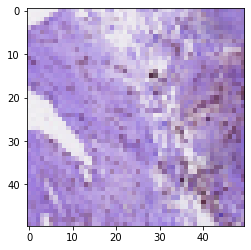

In [152]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.imshow(img_tensor[0])
plt.show()

In [153]:
model.layers

In [154]:
from keras import models

# Extracts the outputs of the top 8 layers:
import tensorflow as tf

layer_outputs = []
layer_names = []
for layer in model.layers[1:]:
    
    try: 
        layer_outputs.append(layer.get_output_at(1))
        layer_names.append(layer.name)
    
    except:
        layer_outputs.append(layer.output)
        layer_names.append(layer.name)

# Creates a model that will return these outputs, given the model input:
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)
activation_model

In [155]:
layer_names

['dense_9',
 'reshape_1',
 'up_block4_conv1',
 'up_block4_conv2',
 'batch_normalization_7',
 'up_block5_conv1',
 'up_block5_conv2',
 'up_sampling2d_3',
 'up_block6_conv1',
 'conv2d_transpose_2']

In [156]:
#model.get_layer('dense_6')

ValueError: No such layer: dense_6. Existing layers are [<keras.engine.input_layer.InputLayer object at 0x7f5f619bf790>, <keras.layers.core.dense.Dense object at 0x7f5f6199ac10>, <keras.layers.core.reshape.Reshape object at 0x7f5f619a1e80>, <keras.layers.convolutional.Conv2DTranspose object at 0x7f5f619a1fd0>, <keras.layers.convolutional.Conv2DTranspose object at 0x7f5f619b96a0>, <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f5f615af310>, <keras.layers.convolutional.Conv2DTranspose object at 0x7f5f615afc70>, <keras.layers.convolutional.Conv2DTranspose object at 0x7f5f61592370>, <keras.layers.convolutional.UpSampling2D object at 0x7f5f61592880>, <keras.layers.convolutional.Conv2DTranspose object at 0x7f5f61592c70>, <keras.layers.convolutional.Conv2DTranspose object at 0x7f5f61592fa0>].

In [162]:
# This will return a list of 5 Numpy arrays:
# one array per layer activation
if 'encoder' in model.name:
    activations = activation_model.predict(img_tensor) #for encoder

if 'decoder' in model.name:
    activations = activation_model.predict(vae_encoder(img_tensor)[0]) #for decoder

len(activations)

10

In [163]:
print(len(activations))
print(len(layer_names))

10
10


In [164]:
first_layer_activation = activations[9]
print(first_layer_activation.shape)
first_layer_activation.shape

(1, 50, 50, 3)


(1, 50, 50, 3)

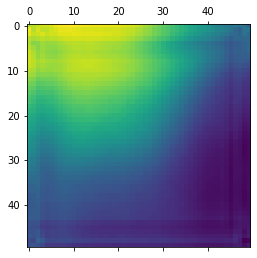

In [165]:
import matplotlib.pyplot as plt

plt.matshow(first_layer_activation[0, :, :, 1], cmap='viridis')
plt.show()

In [ ]:
plt.matshow(first_layer_activation[0,:, :, 8], cmap='viridis')
plt.show()

In [ ]:
activ = first_layer_activation[0,:, :, 5]

In [166]:
import math
def plot_filters(activation_layer, layer_name, counter):
    if len(activation_layer.shape) == 2: # if flat layer
        if activation_layer.shape[1] == 1875:
            activation_layer = activation_layer.reshape(1, 25, 25, 3)
        if activation_layer.shape[1] == 1024:
           activation_layer = activation_layer.reshape(1, 16, 16, 4)
        if activation_layer.shape[1] == 512:
           activation_layer = activation_layer.reshape(1, 8, 8, 8)

    n = math.floor(np.sqrt(activation_layer.shape[3]))

    if int(n + 0.5) ** 2 == activation_layer.shape[3]:

        m = n
    else:
        m = math.floor(activation_layer.shape[3] / n)

    
    if n == 1:
        fig, ax = plt.subplots(1, 3, sharex='col', sharey='row',figsize=(15, 15))
        fig.suptitle(layer_name)
        for i in range(3):
            ax[i].imshow(activation_layer[0,:, :, i], cmap='viridis')
        fig.savefig('img/activations/vae/{}_{}_activations_{}.png'.format(model.name, counter, layer_name))
        return None   

    fig, ax = plt.subplots(n, m, sharex='col', sharey='row',figsize=(15, 15))
    fig.suptitle(layer_name)
    
 

    filter_counter = 0
    for i in range(n):
        for j in range(m):
            ax[i, j].imshow(activation_layer[0,:, :, filter_counter], cmap='viridis')
            filter_counter += 1
            if filter_counter == (activation_layer.shape[3] ):
                break
    
    fig.savefig('img/activations/vae/{}_{}_activations_{}.png'.format(model.name, counter, layer_name))
    return None

In [167]:
for activation, name in zip(activations[0:], layer_names[0:]):
    print(name)
    print(activation.shape)
    

dense_9
(1, 1875)
reshape_1
(1, 25, 25, 3)
up_block4_conv1
(1, 25, 25, 16)
up_block4_conv2
(1, 25, 25, 16)
batch_normalization_7
(1, 25, 25, 16)
up_block5_conv1
(1, 25, 25, 32)
up_block5_conv2
(1, 25, 25, 32)
up_sampling2d_3
(1, 50, 50, 32)
up_block6_conv1
(1, 50, 50, 64)
conv2d_transpose_2
(1, 50, 50, 3)


dense_9
reshape_1
up_block4_conv1
up_block4_conv2
batch_normalization_7
up_block5_conv1
up_block5_conv2
up_sampling2d_3
up_block6_conv1
conv2d_transpose_2


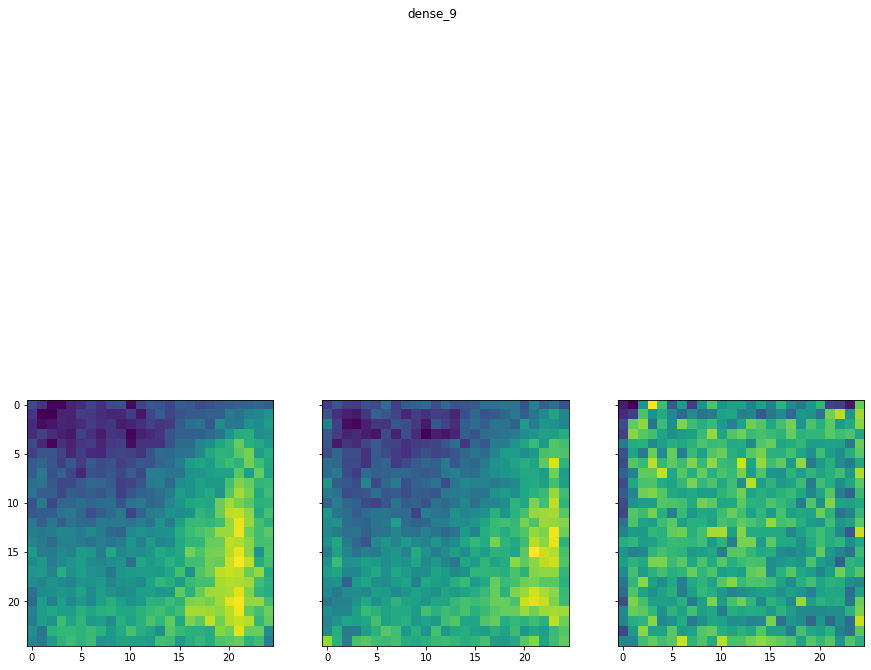

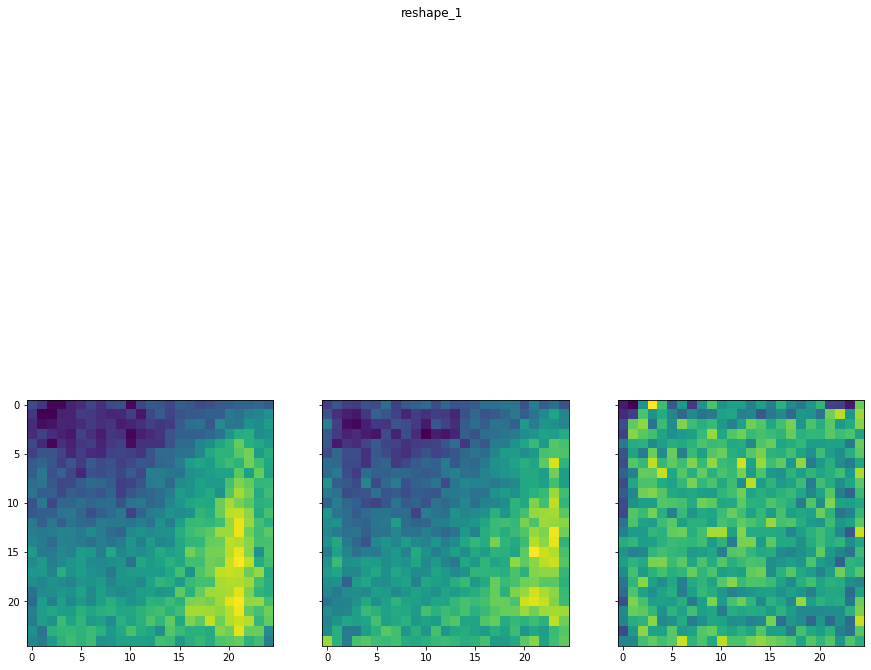

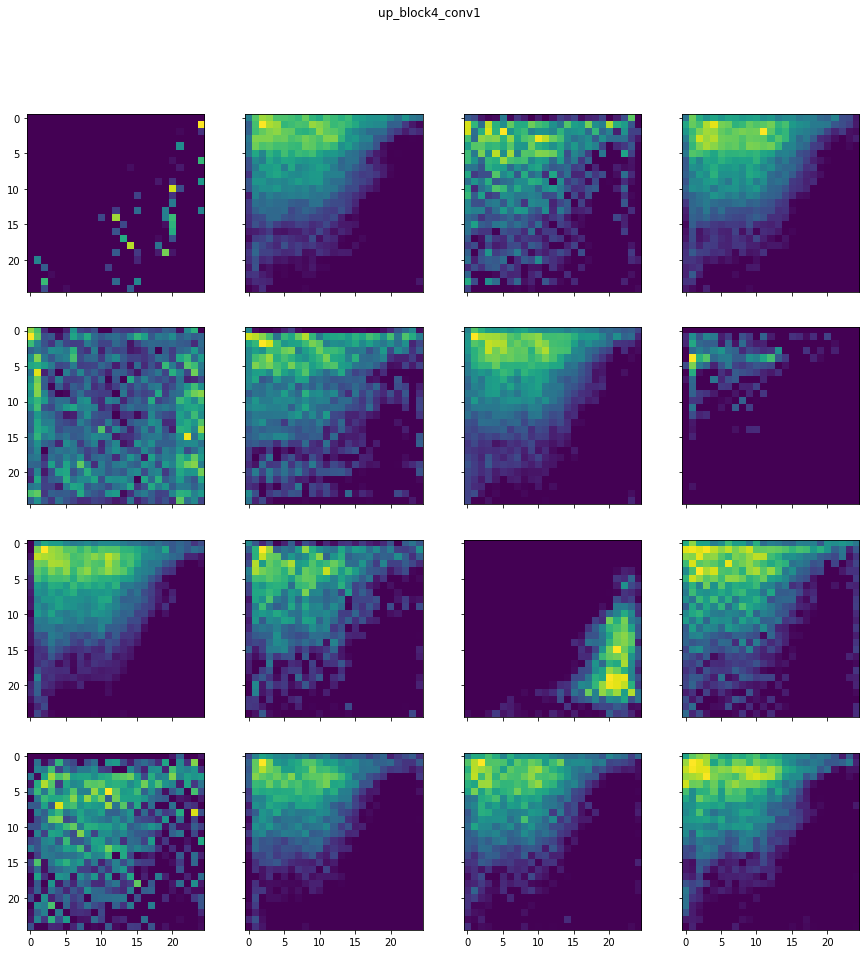

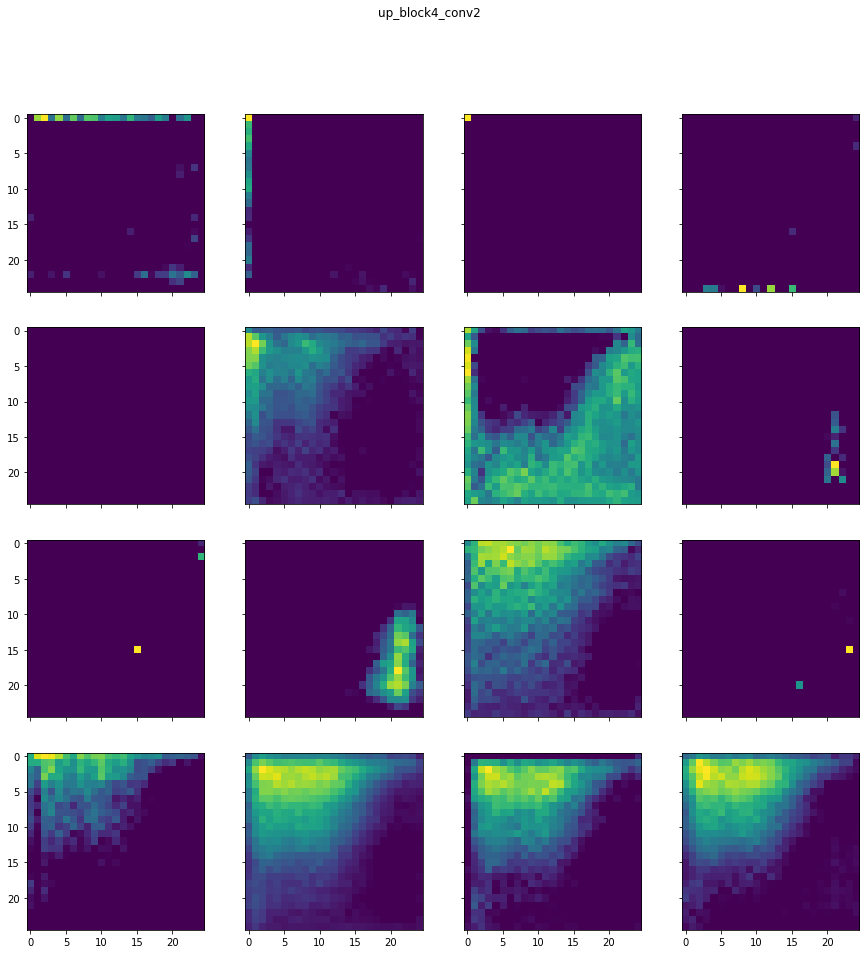

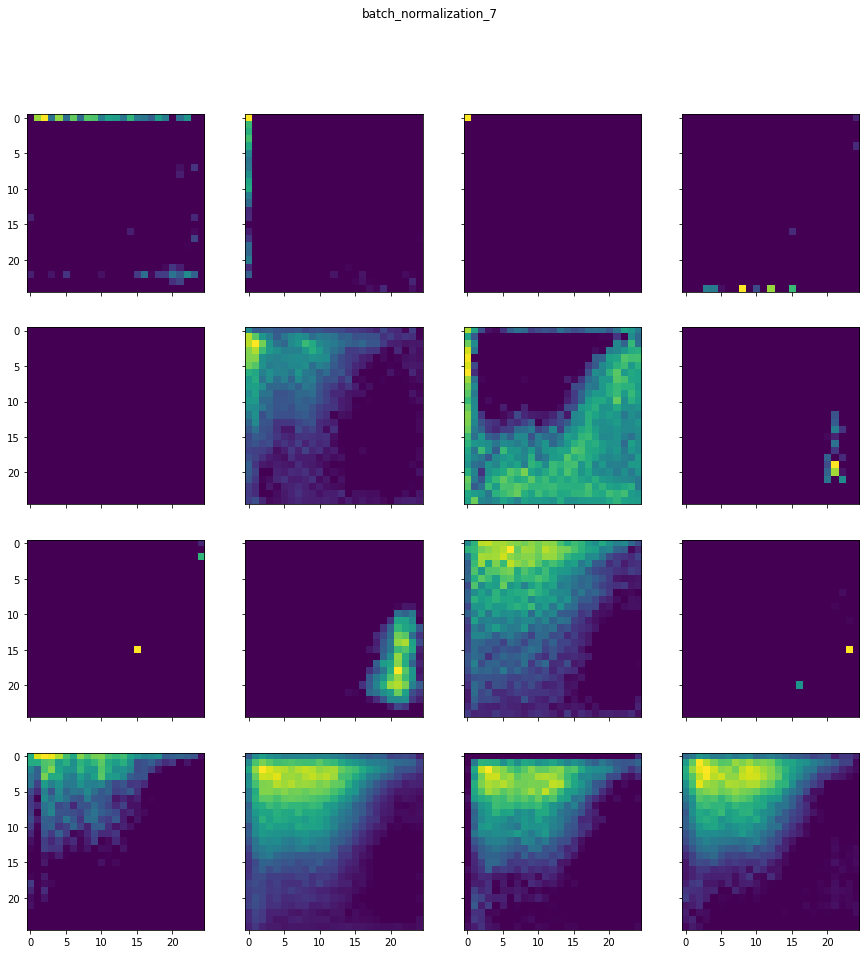

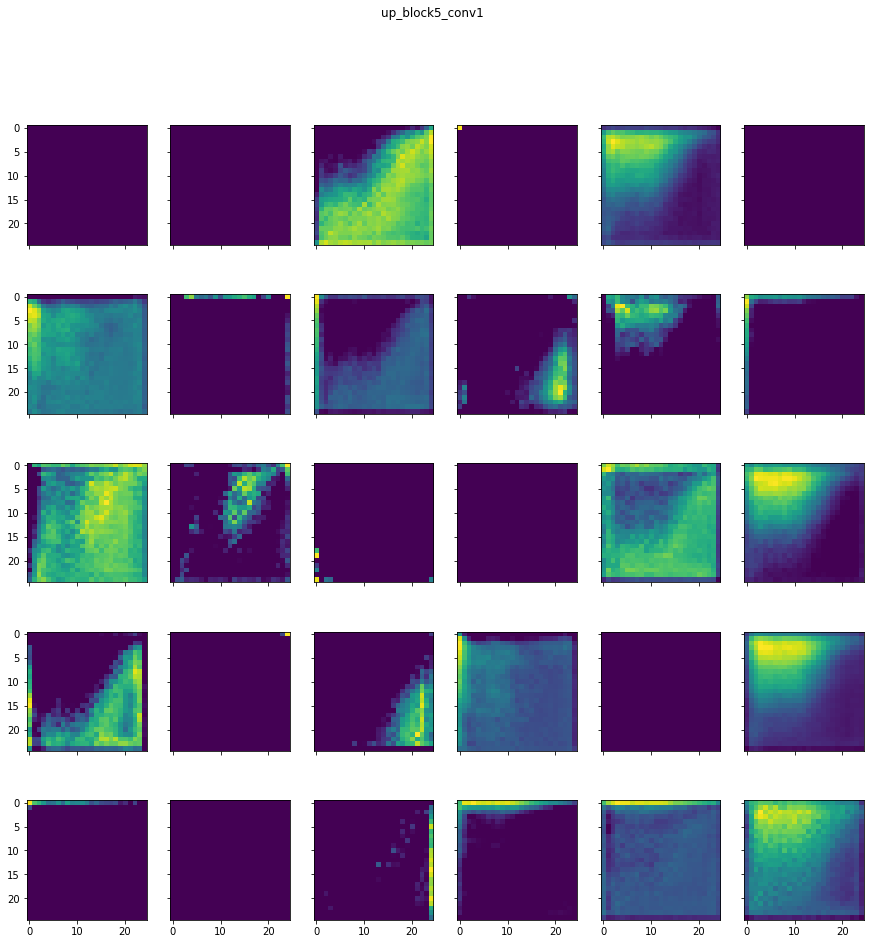

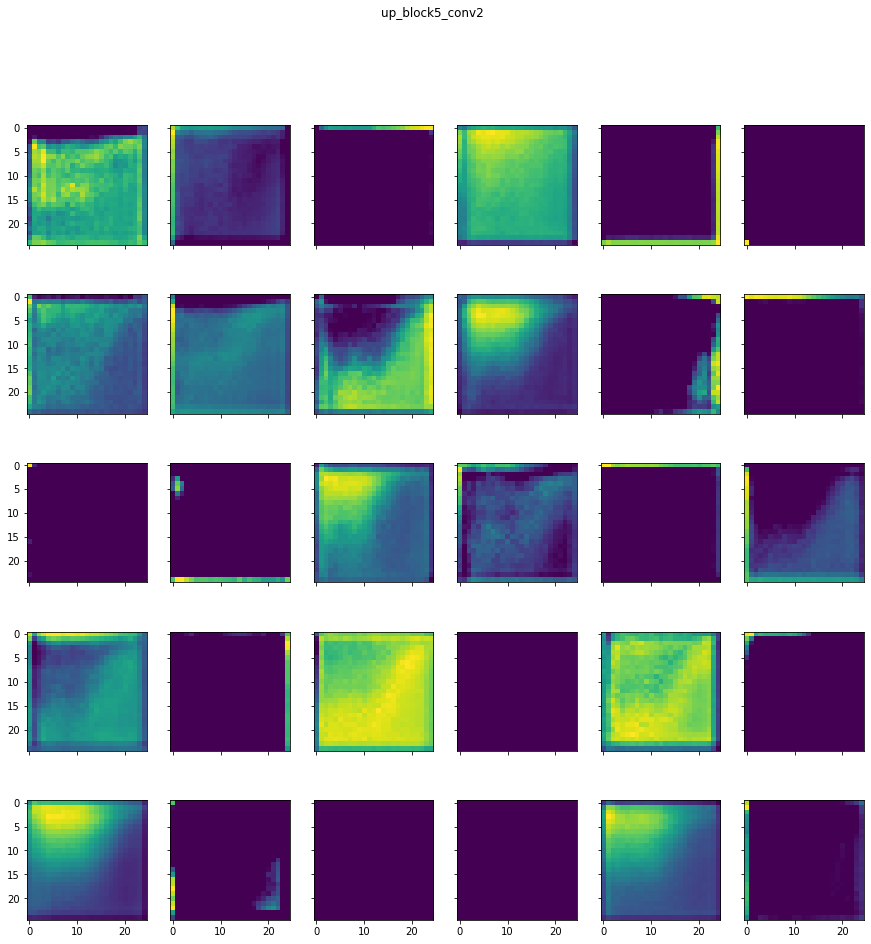

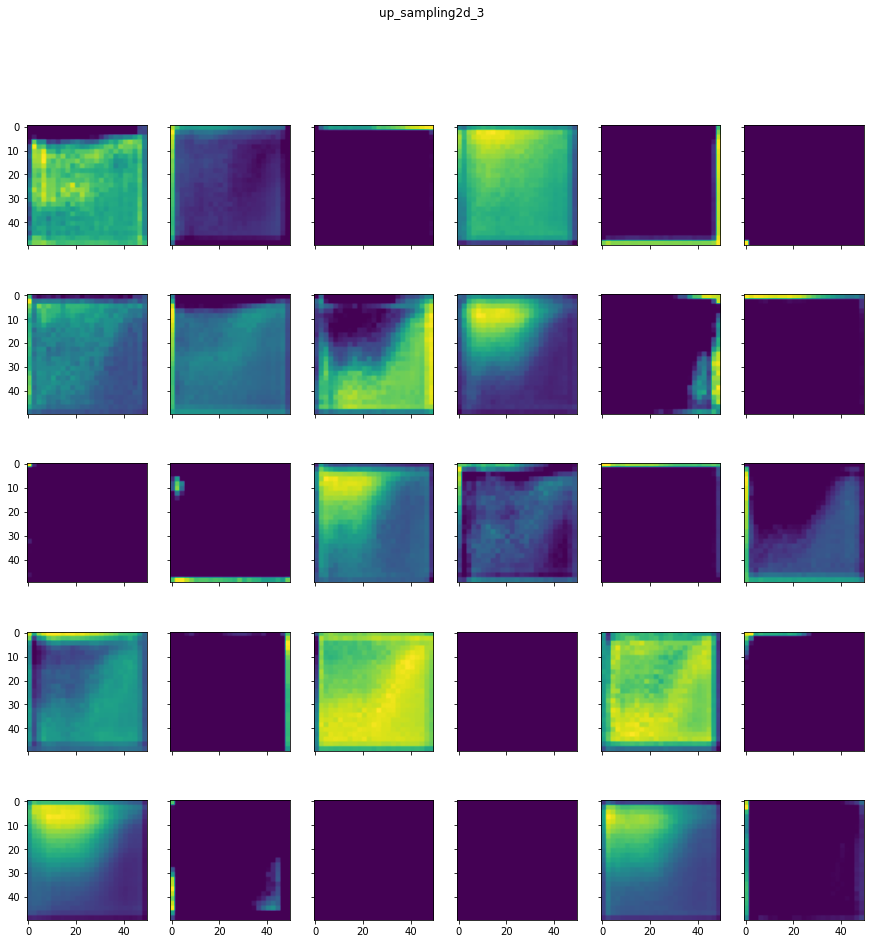

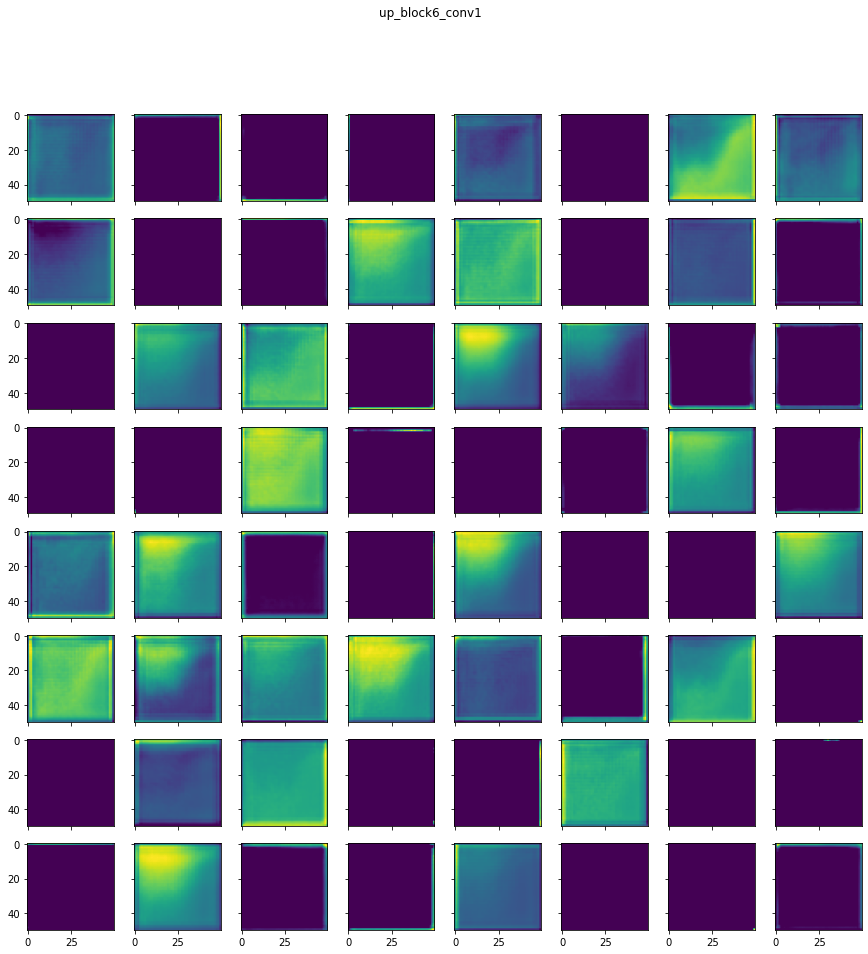

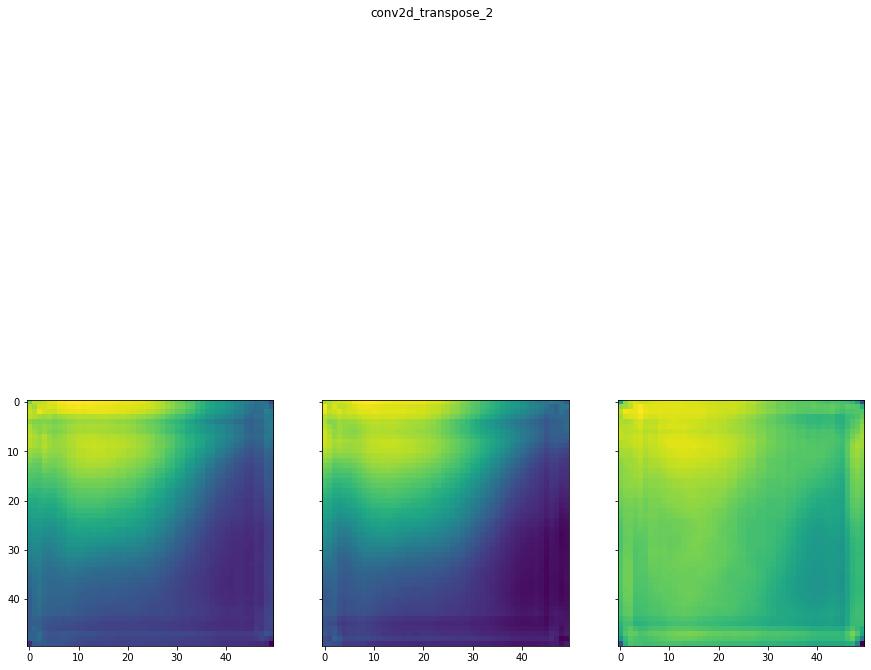

In [168]:
for counter, (activation, name) in enumerate(zip(activations[0:], layer_names[0:])):
    print(name)
    plot_filters(activation, name, counter)
    